# iPython Notebooks Begin Here

## Data Preparation

In [3]:
import os
import pickle

import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import model_from_yaml
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage
from keras.callbacks import EarlyStopping
import sklearn.metrics as skmetrics

import matplotlib.pyplot as plt
%matplotlib inline

### Load training and validation images

In [2]:
train_dir = "data/posters_split/train/"
validation_dir = "data/posters_split/validation/"

In [3]:
train_filenames = os.listdir(train_dir)
n_train = len(train_filenames)

validation_filenames = os.listdir(validation_dir)
n_validation = len(validation_filenames)

In [4]:
# Load train images in arrays
images=[None]*n_train
X=[None]*n_train

for i, train_filename in enumerate(train_filenames):
    images[i] = kimage.load_img(train_dir + train_filename, target_size=(224, 224))
    X[i] = kimage.img_to_array(images[i])
    X[i] = np.expand_dims(X[i], axis=0)
    X[i] = preprocess_input(X[i]).reshape(224,224,3)  

In [5]:
# Load validation images in arrays
val_images=[None]*n_validation
val_X=[None]*n_validation

for i, validation_filename in enumerate(validation_filenames):
    val_images[i] = kimage.load_img(validation_dir + validation_filename, target_size=(224, 224))
    val_X[i] = kimage.img_to_array(val_images[i])
    val_X[i] = np.expand_dims(val_X[i], axis=0)
    val_X[i] = preprocess_input(val_X[i]).reshape(224,224,3)  

### Use pretrained CNN to extract bottleneck features

In [6]:
# Get bottleneck features from pretrained VGG16 
pretrained_model = VGG16(include_top=False, weights='imagenet')

X = np.array(X)
val_X = np.array(val_X)
train_features = pretrained_model.predict(X)
val_features = pretrained_model.predict(val_X)

In [7]:
X.shape

(9291, 224, 224, 3)

### Get genres for each of the movies from their filenames

In [9]:
genre_dict = pickle.load(open("data/genre_dict.pickle", 'rb'))

# Get movie information (including genre labels) for train and validation data from filenames
train_movie_names = os.listdir("data/posters_split/train/")
# Unique id for each movie
train_ids = [filename.split("-")[-1].split("_")[0] for filename in train_movie_names]
train_ids = [int(id) for id in train_ids]
# List of genre ids for each movie
train_genre_ids = [map(int, os.path.splitext(filename)[0].split("-")[-1].split("_")[1:]) for filename in train_movie_names]

val_movie_names = os.listdir("data/posters_split/validation/")
# Unique id for each movie
val_ids = [filename.split("-")[-1].split("_")[0] for filename in val_movie_names]
val_ids = [int(id) for id in val_ids]
# List of genre ids for each movie
val_genre_ids = [map(int, os.path.splitext(filename)[0].split("-")[-1].split("_")[1:]) for filename in val_movie_names]

### Create binary encoded response vectors for train and validation datasets

In [10]:
train_multilabels = pd.DataFrame(index=train_ids)

# multilabel binary encoding by genre
for genre_id, genre in genre_dict.items():
    train_multilabels[genre] = [int(int(genre_id) in genre_list) for genre_list in train_genre_ids]
    
val_multilabels = pd.DataFrame(index=val_ids)

# multilabel binary encoding by genre
for genre_id, genre in genre_dict.items():
    val_multilabels[genre] = [int(int(genre_id) in genre_list) for genre_list in val_genre_ids]

In [6]:
train_multilabels.head()

,War,Mystery,Music,Comedy,History,Western,Animation,Adventure,Drama,Fantasy,Crime,TV Movie,Documentary,Thriller,Science Fiction,Horror,Action,Romance,Family
3133,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
407448,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0
33875,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0
110354,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
51619,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


## Model From Scratch

### Create first convolutional layer

In [30]:
#Single layer CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
Total params: 896.0
Trainable params: 896.0
Non-trainable params: 0.0
_________________________________________________________________


In [32]:
X_1 = np.array(X)
val_X_1 = np.array(val_X)
train_features = model.predict(X_1)
val_features = model.predict(val_X_1)

### Add a fully connected layer on top and train on features from first layer

In [35]:
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_multilabels.shape[1], activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [36]:
type(train_multilabels)

pandas.core.frame.DataFrame

In [43]:
history = model.fit(train_features, train_multilabels.values,
          epochs=10,
          batch_size=16,
          validation_data=(val_features, val_multilabels.values),
          verbose=0)
model.save_weights('bottleneck_fc_model.h5')

In [44]:
score_scr = model.evaluate(train_features, train_multilabels.values, verbose = 0)
print("Train loss: ", score_scr[0])
print('Train accuracy:', score_scr[1])

score_scr = model.evaluate(val_features, val_multilabels.values, verbose=0)
print('Validation loss:', score_scr[0])
print('Validation accuracy:', score_scr[1])

('Train loss: ', 4.1524270704033528)
('Train accuracy:', 0.74058079714411207)
('Validation loss:', 4.1605181167865624)
('Validation accuracy:', 0.7400634412107796)


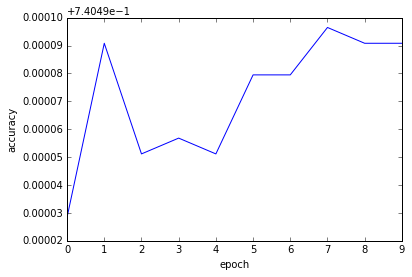

In [45]:
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

### More intense from scratch

In [173]:
#Single layer CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [174]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
activation_116 (Activation)  (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_117 (Activation)  (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 52, 52, 32)        9248      
__________

In [175]:
X_2 = np.array(X)
val_X_2 = np.array(val_X)
train_features = model.predict(X_2)
val_features = model.predict(val_X_2)

In [176]:
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(256, activation='relu', 
                kernel_regularizer = regularizers.l2(0.01), 
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.6))
model.add(Dense(train_multilabels.shape[1], activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

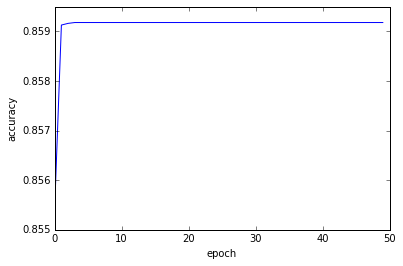

In [177]:
history = model.fit(train_features, train_multilabels.values,
          epochs=50,
          batch_size=16,
          validation_data=(val_features, val_multilabels.values),
          verbose=0)
model.save_weights('conv_6_model.h5')

plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [178]:
out = model.predict_proba(val_features)
out = np.array(out)

y_test = val_multilabels.values

y_pred = np.array([[1 if out[i,j]>=0.5 else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

print '\n '
print 'Scratch CNN Predictions'
print 'hamming loss:', skmetrics.hamming_loss(y_test, y_pred)
print 'jaccard similarity:', skmetrics.jaccard_similarity_score(y_test, y_pred)
print 'zero one loss:', skmetrics.zero_one_loss(y_test, y_pred)
print 'exact match ratio:', skmetrics.accuracy_score(y_test, y_pred)

  32/1160 [..............................] - ETA: 10s
 
Scratch CNN Predictions
hamming loss: 0.138520871143
jaccard similarity: 0.0
zero one loss: 1.0
exact match ratio: 0.0


## Fit Pre-Trained Neural Net
This code was run multiple times on AWS with slight tweaks to get different models.

### Add a fully-connected layer on top and train on bottleneck features

In [7]:
# Train a small fully-connected model on the bottleneck features
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_multilabels.shape[1], activation='sigmoid'))

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_multilabels.values,
          epochs=100,
          batch_size=16,
          validation_data=(val_features, val_multilabels.values),
          verbose=0)
model.save_weights('bottleneck_fc_model.h5')

In [22]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [11]:
train_probs = model.predict_proba(train_features)

9216/9291 [============================>.] - ETA: 0s 

In [12]:
train_probs.shape

(9291, 19)

In [13]:
val_probs = model.predict_proba(val_features)

1088/1160 [===========================>..] - ETA: 0s

In [14]:
val_probs.shape

(1160, 19)

In [18]:
# save train and validation probabilities and actual values
np.save(open('train_probs.npy', 'w'), train_probs)
np.save(open('val_probs.npy', 'w'), val_probs)
np.save(open('train_multilabels.npy', 'w'), train_multilabels)
np.save(open('val_multilabels.npy', 'w'), val_multilabels)

### Loading model from yaml
We saved some models for quick loading.

In [5]:
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)
# load weights into new model
model.load_weights("bottleneck_fc_model.h5")
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Evaluation of performance

In [17]:
# built-in accuracy and loss
score = model.evaluate(train_features, train_multilabels.values, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = model.evaluate(val_features, val_multilabels.values, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

('Train loss:', 0.18188104101151673)
('Train accuracy:', 0.90423656116837048)
('Validation loss:', 0.52511948552624932)
('Validation accuracy:', 0.86810332701123993)


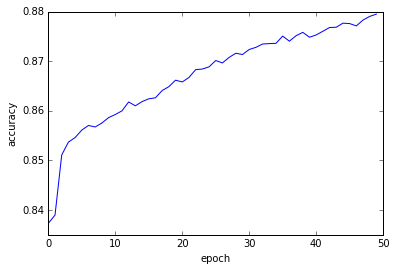

In [15]:
# training progress
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [ ]:
out = model.predict_proba(val_features)
out = np.array(out)

y_test = val_multilabels.values    
y_pred = np.array([[1 if out[i,j]>=0.5 else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

In [ ]:
print 'hamming loss:', skmetrics.hamming_loss(y_test, y_pred)
print 'jaccard similarity:', skmetrics.jaccard_similarity_score(y_test, y_pred)
print 'zero one loss:', skmetrics.zero_one_loss(y_test, y_pred)
print 'exact match ratio:', skmetrics.accuracy_score(y_test, y_pred)

## Naive Baseline Models + Additional Metrics
* all zeroes
* all ones
* most common set of genres
* per-genre accuracy

In [6]:
import os
import pickle

import numpy as np
import pandas as pd
import sklearn.metrics as skmetrics
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
out = open('data/cols.pkl', 'r')
cols = pickle.load(out)
y_pred = pd.DataFrame(np.load('data/y_pred.npy'), columns = cols)
y_test = pd.DataFrame(np.load('data/y_test.npy'), columns = cols)

### All Zeros

In [9]:
zeros = np.zeros(y_test.shape)
print 'hamming loss:', skmetrics.hamming_loss(y_test, zeros)
print 'jaccard similarity:', skmetrics.jaccard_similarity_score(y_test, zeros)
print 'zero one loss:', skmetrics.zero_one_loss(y_test, zeros)
print 'exact match ratio:', skmetrics.accuracy_score(y_test, zeros)

hamming loss: 0.138520871143
jaccard similarity: 0.0
zero one loss: 1.0
exact match ratio: 0.0


### All Ones

In [10]:
ones = np.ones(y_test.shape)
print 'hamming loss:', skmetrics.hamming_loss(y_test, ones)
print 'jaccard similarity:', skmetrics.jaccard_similarity_score(y_test, ones)
print 'zero one loss:', skmetrics.zero_one_loss(y_test, ones)
print 'exact match ratio:', skmetrics.accuracy_score(y_test, ones)

hamming loss: 0.861479128857
jaccard similarity: 0.138520871143
zero one loss: 1.0
exact match ratio: 0.0


### Most Common Set of Genres

In [11]:
count = Counter()
for index, row in y_test.iterrows():
    count[tuple(row)] += 1
print "most common combo:", count.most_common(1)[0][0]
print "appears {} times".format(count.most_common(1)[0][1])

most common combo: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0)
appears 72 times


In [12]:
most_common = pd.Series(count.most_common(1)[0][0]).to_frame().T
most_common.columns = cols
naive = pd.concat([most_common] * len(y_test))

In [13]:
naive.head()

,War,Mystery,Music,Comedy,History,Western,Animation,Adventure,Drama,Fantasy,Crime,TV Movie,Documentary,Thriller,Science Fiction,Horror,Action,Romance,Family
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [14]:
print 'hamming loss:', skmetrics.hamming_loss(y_test, naive)
print 'jaccard similarity:', skmetrics.jaccard_similarity_score(y_test, naive)
print 'zero one loss:', skmetrics.zero_one_loss(y_test, naive)
print 'exact match ratio:', skmetrics.accuracy_score(y_test, naive)

hamming loss: 0.179809437387
jaccard similarity: 0.0827586206897
zero one loss: 0.937931034483
exact match ratio: 0.0620689655172


### Per Genre Accuracy

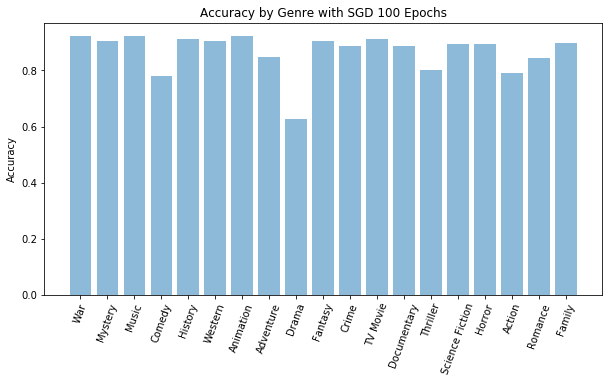

In [28]:
genre_acc = []
for genre in cols:
    genre_acc.append((y_test[genre] == y_pred[genre]).mean())
    
# plot
plt.figure(figsize=(10, 5))
y_pos = np.arange(len(cols))
plt.bar(y_pos, genre_acc, align='center', alpha=0.5)
plt.xticks(y_pos, cols)
plt.xticks(rotation=70)
plt.ylabel('Accuracy')
plt.title('Accuracy by Genre with SGD 100 Epochs')
plt.show()

## Additional Exploratory Ideas

### Find the optimum threshold values on the training set

In [4]:
out = train_probs
y_test = train_multilabels

In [5]:
acc = []
accuracies = []
best_threshold = np.zeros(out.shape[1])
threshold = np.arange(0.1, 0.9, step=0.05)
for i in range(out.shape[1]):
    y_prob = np.array(out[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        acc.append(matthews_corrcoef(y_test[:,i],y_pred))
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    accuracies.append(acc.max()) 
    best_threshold[i] = threshold[index[0][0]]
    acc = []

/Users/harryxue/anaconda/envs/keras/lib/python2.7/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


In [6]:
best_threshold

array([ 0.2 ,  0.2 ,  0.25,  0.2 ,  0.25,  0.25,  0.3 ,  0.2 ,  0.4 ,
        0.1 ,  0.3 ,  0.15,  0.25,  0.25,  0.15,  0.3 ,  0.25,  0.25,  0.25])

In [7]:
val_pred = np.array([[int(val_probs[i,j]>=best_threshold[j]) for j in range(val_probs.shape[1])] for i in range(len(val_probs))])

In [20]:
val_pred.shape

(1160, 19)

In [10]:
# Save thresholded predictions
np.save('data/val_pred_thresholded.np', val_pred)

In [26]:
from sklearn import metrics as skmetrics

In [27]:
print 'Neural Net Predictions'
print 'hamming loss:', skmetrics.hamming_loss(val_pred, val_multilabels)
print 'jaccard similarity:', skmetrics.jaccard_similarity_score(val_pred, val_multilabels)
print 'zero one loss:', skmetrics.zero_one_loss(val_pred, val_multilabels)
print 'exact match ratio:', skmetrics.accuracy_score(val_pred, val_multilabels)

Neural Net Predictions
hamming loss: 0.197277676951
jaccard similarity: 0.242022685169
zero one loss: 0.978448275862
exact match ratio: 0.0215517241379


In [28]:
all_zeros = np.zeros((1160, 19))

In [29]:
print 'hamming loss:', skmetrics.hamming_loss(all_zeros, val_multilabels)


hamming loss: 0.138520871143
